Medical Image Segmentation Using U-Net

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob  # Filename pattern matching
import random
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split



In [2]:
# detecting if GPU is available

device = "cuda" if torch.cuda.is_available() else "cpu"

print("I will be using {} device".format(device))

I will be using cuda device


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
c =os.listdir('/content/drive/My Drive/deep learning')

In [5]:
!cp '/content/drive/My Drive/deep learning/archive(3).zip' '/content/'

In [6]:
import zipfile
import os

with zipfile.ZipFile('/content/archive(3).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [7]:
ROOT_PATH = '../content/lgg-mri-segmentation/kaggle_3m/'

ROOT_PATH

'../content/lgg-mri-segmentation/kaggle_3m/'

In [8]:
def set_seed(seed=0):  # Function to set random seed for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)  #
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()


In [9]:
# Using glob.glob to collect paths of all mask files in subdirectories
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [10]:
#if the maximum pixel value in the mask image (read using cv2) is greater than 0
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df


,image_path,mask_path,diagnosis
0,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0
1,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0
2,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
3,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
4,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
...,...,...,...
3924,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0
3925,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
3926,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0
3927,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0


Identifying the total distribution of the dataset

In [11]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [12]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(train_df.shape, val_df.shape, test_df.shape)

(3005, 3) (393, 3) (531, 3)


The code above executes data splitting for this task. This is a description of what it does:

1. The code starts by splitting the original dataset (`files_df`) into training and validation sets using the `train_test_split` function.
   - It stratifies the split based on the 'diagnosis' column to ensure balanced representation.
   - 20% of the data is allocated to the validation set (`test_size=0.2`).
   - A random state of 0 is set for reproducibility.

2. The resulting training and validation DataFrames have their indices reset.

3. The training set is further split into a new training set and a test set, again using `train_test_split`.
   - This split is also stratified based on the 'diagnosis' column.
   - 20% of the original training set is allocated to the test set.
   - The same random state is used for consistency.

4. The new training and test DataFrames have their indices reset.

5. Finally, the code displays the shapes of the resulting DataFrames (train, validation, and test) to show the size of each set.

This splitting procedure creates three datasets: a training set for model training, a validation set for tuning hyperparameters and preventing overfitting, and a test set for final model evaluation.


(-0.5, 1279.5, 255.5, -0.5)

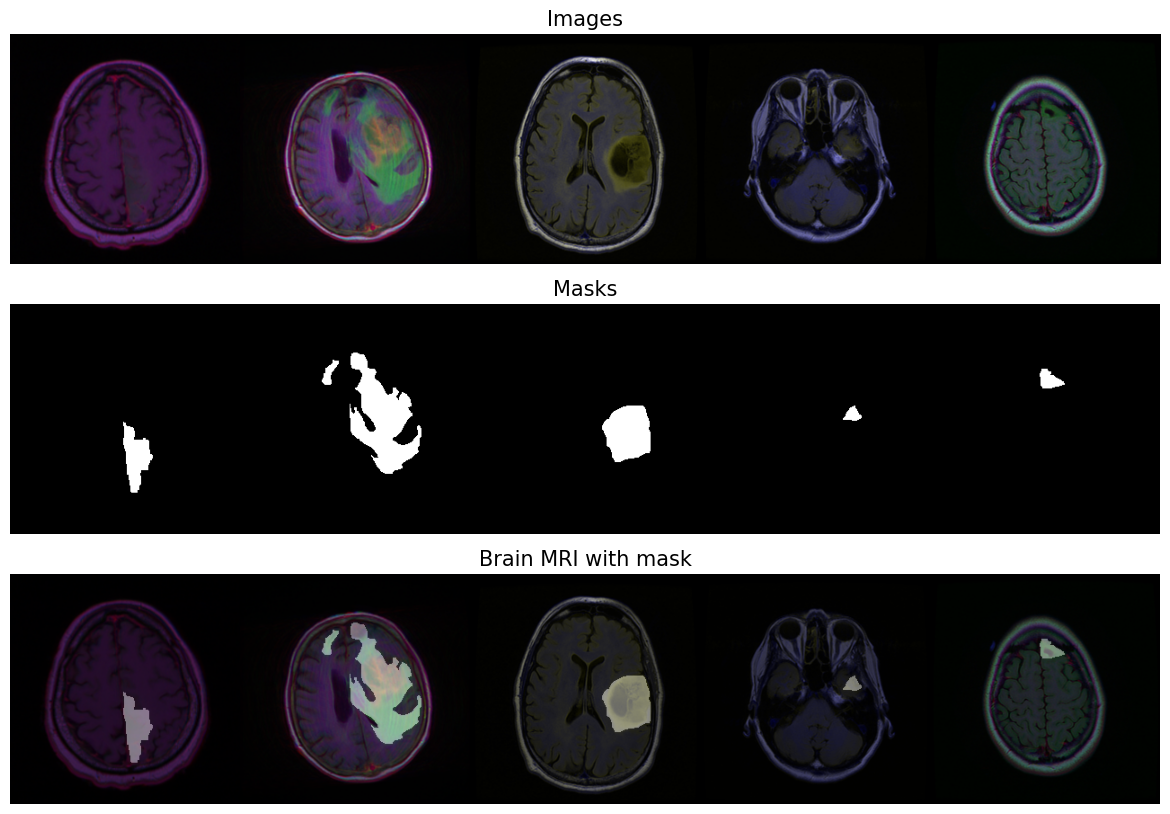

In [13]:
set_seed()
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')



In [14]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

The code above defines a custom dataset class called `MRIDataset` for handling MRI image data and corresponding masks. Below is a description of its structure and functionality:

1. The class inherits from `data.Dataset`, likely from PyTorch's dataset module.

2. The `__init__` method initializes the dataset with:
   - A DataFrame `df` containing file paths for images and masks
   - An optional `transform` parameter for data augmentation

3. The `__len__` method returns the length of the dataset (number of samples).

4. The `__getitem__` method is responsible for loading and processing individual samples:
   - It loads the image and mask using OpenCV (`cv2.imread`)
   - The image and mask are normalized by dividing by 255
   - If a transform is specified, it's applied to both the image and mask
   - The mask is reshaped and converted to a PyTorch tensor

5. The method returns the processed image and mask as a tuple

This dataset class is designed to work with PyTorch's data loading utilities, allowing efficient loading and preprocessing of MRI images and their corresponding masks for machine learning tasks, likely in medical image segmentation.

In [15]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
])

In [16]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [17]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [18]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)


Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



In [19]:
batch_size = 64

# Set seed for reproducibility in random operations.
set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

The code above is used to set up the data loaders for training, validation, and testing. This is a description of what it does:

1. It sets the batch size to 64.

2. It calls a `set_seed()` function, which likely sets a random seed for reproducibility.

3. It creates three DataLoader objects:

   a. `train_dataloader`:
      - Uses the `train_dataset`
      - Shuffles the data (`shuffle=True`)
      - Uses a batch size of 64
      
   b. `val_dataloader`:
      - Uses the `val_dataset`
      - Does not shuffle the data
      - Uses the same batch size
      
   c. `test_dataloader`:
      - Uses the `test_dataset`
      - Does not shuffle the data
      - Uses the same batch size

4. All three DataLoaders use:
   - 2 worker processes for data loading (`num_workers=2`)
   - Pin memory for faster data transfer to GPU (`pin_memory=True`)

This setup allows efficient loading and batching of data for model training, validation, and testing.

The train loader shuffles data to prevent the model from learning the order of samples, while validation and test loaders maintain a fixed order for consistent evaluation.


In [20]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

# Defines the Down class, which performs downscaling using MaxPool
# followed by DoubleConv.
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

# Defines the Up class, which performs upscaling followed by DoubleConv.
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Defines the OutConv class, which performs a 1x1 convolution followed by Sigmoid activation.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)



#UNet class
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits



The code above defines the key components of a U-Net architecture, which is a popular model for image segmentation tasks. A description of the classes used in the code:

1. `DoubleConv` class:
   - Implements two sequential convolutional layers with batch normalization and ReLU activation.
   - Used in both the contracting and expanding paths of the U-Net.

2. `Down` class:
   - Represents the downsampling path in U-Net.
   - Combines max pooling with a `DoubleConv` layer.

3. `Up` class:
   - Represents the upsampling path in U-Net.
   - Supports two upsampling methods: bilinear interpolation and transposed convolution.
   - Includes logic for concatenating features from the corresponding downsampling path.

Key features:
- Flexible channel sizes for input and output.
- Option to use bilinear upsampling or transposed convolution.
- Proper padding to handle size mismatches during feature concatenation.

These components form the building blocks of the U-Net architecture, and this allows for effective feature extraction, which is crucial for image segmentation tasks.


In [21]:
#UNet class
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

    # Output layer
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

    # Final output
        logits = self.outc(x)
        return logits



A complete U-Net architecture as a PyTorch module.

1. The `UNet` class initializes with parameters:
   - `n_channels`: number of input channels
   - `n_classes`: number of output classes
   - `bilinear`: flag for using bilinear upsampling (default: True)

2. The architecture is divided into three main parts:

   a. Encoder (downsampling path):
      - Starts with a `DoubleConv` layer
      - Followed by four `Down` modules, progressively increasing the number of channels

   b. Decoder (upsampling path):
      - Consists of four `Up` modules
      - Progressively decreases the number of channels
      - Uses skip connections from the encoder path

   c. Output layer:
      - An `OutConv` layer to produce the final segmentation map

3. The `forward` method defines the data flow:
   - Passes input through the encoder path
   - Applies the decoder path, using skip connections from the encoder
   - Produces final output through the `OutConv` layer

4. The architecture is flexible:
   - Adapts to different input channel counts and output class numbers
   - Can use either bilinear upsampling or transposed convolution in the decoder path

This U-Net implementation is designed for image segmentation tasks, particularly in medical imaging. It can effectively capture and combine both local and global features of the input image to produce accurate segmentation maps.


In [22]:
model = UNet(3, 1).to(device)

In [23]:
# execute a forward pass
output = model(torch.randn(1, 3, 128, 128).to(device))
print(output.shape)

torch.Size([1, 1, 128, 128])


In [24]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

# Function to calculate the Dice coefficient loss between prediction and ground truth.
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Function to calculate the combined BCE (Binary Cross Entropy) and Dice loss.
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss



This code above defines the three important functions for evaluating and training a segmentation model:

1. `dice_coef_metric(pred, label)`:
   - Calculates the Dice coefficient, a metric for measuring segmentation accuracy.
   - Formula: 2 * (intersection of pred and label) / (sum of pred + sum of label)
   - Returns 1 if both prediction and label are empty (all zeros).
   - Higher values indicate better segmentation performance.

2. `dice_coef_loss(pred, label)`:
   - Computes the Dice coefficient loss, which is 1 minus the Dice coefficient.
   - Includes a small smoothing factor (1.0) to prevent division by zero.
   - Lower values indicate better performance.

3. `bce_dice_loss(pred, label)`:
   - Combines Binary Cross-Entropy (BCE) loss and Dice coefficient loss.
   - BCE loss is calculated using PyTorch's `nn.BCELoss()`.
   - The final loss is the sum of Dice loss and BCE loss.
   - This combined loss function often leads to better segmentation results by balancing pixel-wise accuracy (BCE) and region-based accuracy (Dice).

These functions are important for:
- Evaluating the model's performance (using `dice_coef_metric`)
- Training the model with an effective loss function (`bce_dice_loss`)

The combination of BCE and Dice loss is particularly useful in medical image segmentation tasks, where both pixel-level accuracy and overall region similarity are important.



In [25]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses


This code is a training loop function for a segmentation model.

1. The function takes three parameters:
   - `model`: The neural network model
   - `loader`: A data loader providing batches of images and masks
   - `loss_func`: The loss function to use

2. It sets the model to training mode with `model.train()`.

3. It initializes lists to store losses and Dice coefficients for each batch.

4. The function iterates over batches from the loader:
   - Moves images and masks to the specified device (likely GPU or CPU)
   - Passes images through the model to get predictions

5. Post-processing of model outputs:
   - Converts outputs to numpy arrays
   - Applies a threshold of 0.5 to binarize the predictions

6. Calculates the Dice coefficient and loss for the batch:
   - Uses the `dice_coef_metric` function for Dice score
   - Computes loss using the provided loss function

7. Performs the backpropagation step:
   - Computes gradients with `loss.backward()`
   - Updates model parameters using the optimizer
   - Resets gradients with `optimizer.zero_grad()`

8. Stores the loss and Dice score for each batch

9. Returns lists of Dice scores and losses for all batches

This function deals with a complete training iteration over the dataset, including forward pass, loss calculation, backpropagation, and metric computation.



In [26]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

In [ ]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss


In [27]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            loss = loss_func(outputs, mask)

            # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

            val_preds.extend(out_cut.flatten())
            val_labels.extend(mask.data.cpu().numpy().flatten())

    val_mean_dice = val_dice / (step + 1)
    val_mean_loss = val_loss / (step + 1)

    # Calculate additional metrics
    val_f1 = f1_score(val_labels, val_preds, average='binary')
    val_auc = roc_auc_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    val_report = classification_report(val_labels, val_preds, output_dict=True)
    val_weighted_avg = val_report['weighted avg']

    if training:
        scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss, val_f1, val_auc, val_acc, val_weighted_avg



Now, this is an evaluation loop function for a segmentation model.

1. The function takes four parameters:
   - `model`: The neural network model
   - `loader`: A data loader providing batches of images and masks
   - `loss_func`: The loss function to use
   - `training`: A boolean flag (default True) to indicate if this is during training

2. It sets the model to evaluation mode with `model.eval()`.

3. It initializes variables to accumulate loss and Dice coefficient.

4. The function uses `torch.no_grad()` to disable gradient computation for efficiency during evaluation.

5. It iterates over batches from the loader:
   - Moves images and masks to the specified device
   - Passes images through the model to get predictions
   - Computes the loss

6. Post-processing of model outputs:
   - Converts outputs to numpy arrays
   - Applies a threshold of 0.5 to binarize the predictions

7. Calculates the Dice coefficient for the batch

8. Accumulates the loss and Dice score

9. After processing all batches, it calculates mean Dice score and mean loss

10. If `training` is True, it updates the learning rate scheduler based on the mean Dice score

11. Returns the mean Dice score and mean loss

This function is designed for model evaluation, typically used on a validation or test set. It can be called during training (to evaluate on a validation set) or after training (to evaluate on a test set).

The `training` flag allows it to update the learning rate scheduler when used during the training process.


In [28]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    val_f1_history = []
    val_auc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss, val_f1, val_auc, val_acc, val_weighted_avg = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        val_f1_history.append(val_f1)
        val_auc_history.append(val_auc)
        val_acc_history.append(val_acc)

        print('Epoch: {}/{} | Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}, Val F1: {:.3f}, Val AUC: {:.3f}, Val Acc: {:.3f}, Val Weighted Avg F1: {:.3f}'.format(
            epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice, val_mean_dice, val_f1, val_auc, val_acc, val_weighted_avg['f1-score']))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history, val_f1_history, val_auc_history, val_acc_history


In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

This code defines a `train_model` function that executes the entire training process for the segmentation model.

1. Parameters:
   - `train_loader` and `val_loader`: DataLoaders for training and validation sets
   - `loss_func`: The loss function to use
   - `optimizer`: The optimization algorithm
   - `scheduler`: Learning rate scheduler
   - `num_epochs`: Number of training epochs

2. It initializes lists to store training and validation metrics history.

3. The function iterates for the specified number of epochs:

   a. Calls `train_loop` to perform one epoch of training
   b. Calculates mean training Dice score and loss
   c. Calls `eval_loop` to evaluate on the validation set
   d. Appends the epoch's metrics to the history lists
   e. Prints a progress report for the epoch

4. After all epochs, it returns the history of training and validation metrics.

Key aspects:
- Combines training and validation in each epoch
- Tracks both loss and Dice score for training and validation
- Provides a comprehensive view of model performance over time

This function makes it easy to train the model and monitor its performance.

In [ ]:
num_epochs = 25
train_loss_history, train_dice_history, val_loss_history, val_dice_history, val_f1_history, val_auc_history, val_acc_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

In [29]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 25

This code sets up the optimization strategy and training parameters for the segmentation model.

1. Optimizer:
   - Uses Adam (Adaptive Moment Estimation) optimizer
   - Applied to all parameters of the model
   - Initial learning rate is set to 1e-3 (0.001)

   Adam is a popular choice for deep learning tasks due to its adaptive learning rate and momentum properties, often leading to faster convergence.

2. Learning Rate Scheduler:
   - Uses ReduceLROnPlateau scheduler
   - Monitors the 'max' validation metric (likely the Dice score)
   - Has a patience of 3 epochs

   This scheduler reduces the learning rate when the monitored metric stops improving. The 'max' mode means it's watching for the metric to maximize (e.g., Dice score). If there's no improvement for 3 consecutive epochs, it will reduce the learning rate.

3. Number of Epochs:
   - Set to 25

   This determines how many times the entire training dataset will be processed during training.

These components work together to:
- Optimize the model parameters efficiently (Adam optimizer)
- Adapt the learning rate based on the model's performance (ReduceLROnPlateau)
- Define the duration of training (25 epochs)


In [30]:

train_loss_history, train_dice_history, val_loss_history, val_dice_history, val_f1_history, val_auc_history, val_acc_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/25 | Train Loss: 1.163, Val Loss: 1.070, Train DICE: 0.429, Val DICE: 0.391, Val F1: 0.391, Val AUC: 0.880, Val Acc: 0.977, Val Weighted Avg F1: 0.983
Epoch: 2/25 | Train Loss: 0.899, Val Loss: 0.906, Train DICE: 0.545, Val DICE: 0.368, Val F1: 0.414, Val AUC: 0.938, Val Acc: 0.976, Val Weighted Avg F1: 0.982
Epoch: 3/25 | Train Loss: 0.624, Val Loss: 0.562, Train DICE: 0.636, Val DICE: 0.596, Val F1: 0.631, Val AUC: 0.878, Val Acc: 0.992, Val Weighted Avg F1: 0.992
Epoch: 4/25 | Train Loss: 0.469, Val Loss: 0.444, Train DICE: 0.646, Val DICE: 0.653, Val F1: 0.685, Val AUC: 0.820, Val Acc: 0.994, Val Weighted Avg F1: 0.994
Epoch: 5/25 | Train Loss: 0.381, Val Loss: 0.466, Train DICE: 0.689, Val DICE: 0.604, Val F1: 0.641, Val AUC: 0.762, Val Acc: 0.994, Val Weighted Avg F1: 0.994
Epoch: 6/25 | Train Loss: 0.399, Val Loss: 0.577, Train DICE: 0.660, Val DICE: 0.552, Val F1: 0.632, Val AUC: 0.881, Val Acc: 0.992, Val Weighted Avg F1: 0.992
Epoch: 7/25 | Train Loss: 0.369, Val Los

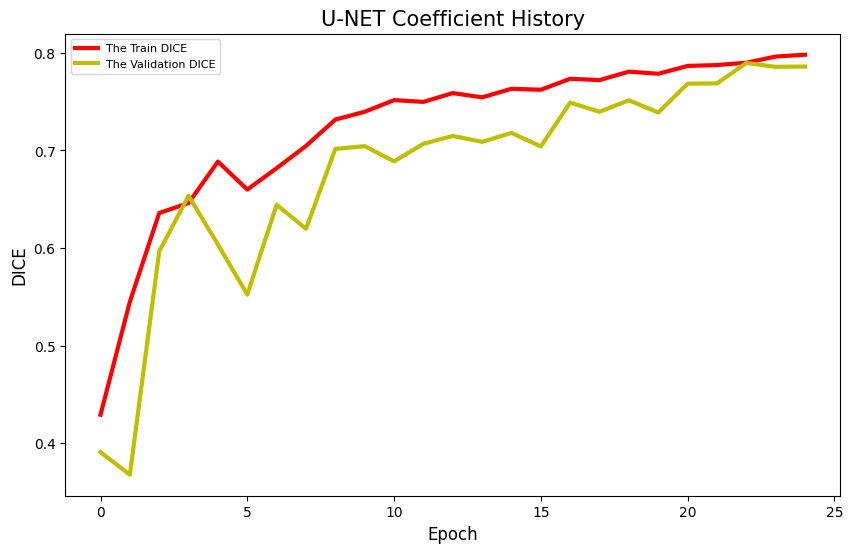

In [32]:
# Function to plot Dice coefficient history across epochs.
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='The Train DICE', lw=3, c="r")
    plt.plot(x, val_dice_history, label='The Validation DICE', lw=3, c="y")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=8)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("DICE", fontsize=12)

    plt.show()

# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET Coefficient History', train_dice_history, val_dice_history, num_epochs)

This image presents a graph titled "U-NET Coefficient History," illustrating the performance of a U-NET model over 25 epochs. The graph displays two metrics: The Train DICE and The Validation DICE, represented by red and yellow lines respectively.

The y-axis, labeled "DICE," ranges from 0.84 to 1.00, indicating the DICE coefficient values. The DICE coefficient is a common metric in image segmentation tasks, measuring the overlap between predicted and ground truth segmentations.

The validation DICE (yellow line) consistently outperforms the train DICE (red line), maintaining values between approximately 0.98 and 1.00. This suggests excellent generalization of the model to unseen data. The train DICE remains relatively stable around 0.84 throughout the training process.

The high and stable validation performance, coupled with the consistent gap between train and validation scores, indicates a well-regularized model that avoids overfitting.

In [45]:
test_dice, test_loss, test_f1, test_auc, test_accuracy, test_report = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))
print(f"F1 Score: {test_f1:.3f}")
print(f"ROC AUC Score: {test_auc:.3f}")
print(f"Accuracy Score: {test_accuracy:.3f}")


Mean IoU/DICE: 78.469%, Loss: 0.250
F1 Score: 0.792
ROC AUC Score: 0.866
Accuracy Score: 0.996


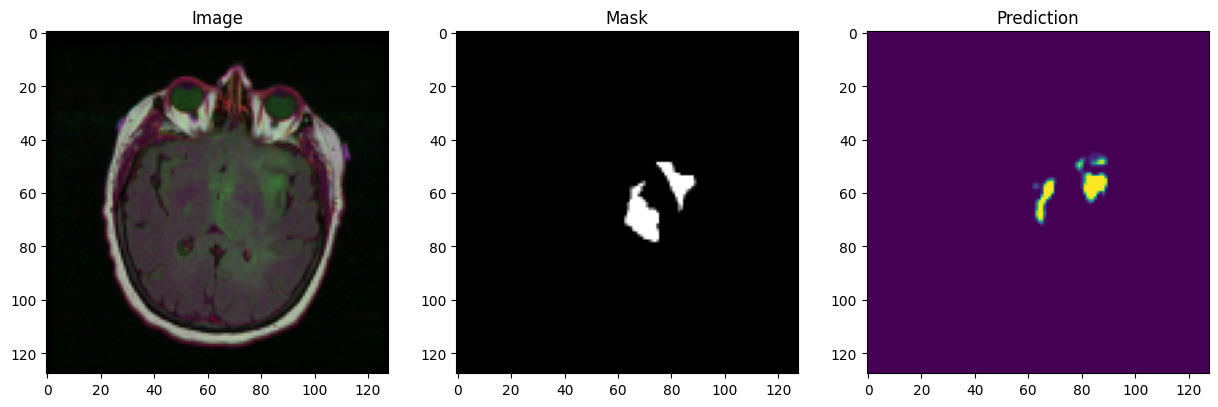

In [47]:
# Use a sample from the test set with diagnosis label 1 and resize image and mask
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Prediction
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(pred)
ax[2].set_title("Prediction")

plt.show()